In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, roc_auc_score, auc, precision_recall_curve
import lime
import lime.lime_tabular

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV




In [2]:
df = pd.read_csv("Datos_regresion.csv") # read in data downloaded to the local directory
df.head()

,Edad,Diag.Ing1,Diag.Ing2,Diag.Egr1,Diag.Egr2,APACHE,TiempoVAM,Fallece
0,35,1,0,1,0,10,2,0
1,87,2,0,2,0,16,2,0
2,70,4,0,4,0,11,2,0
3,24,13,0,13,5,11,2,0
4,24,3,0,3,0,17,3,0


In [3]:
# Verificamos si hay algún elemento nulo
df.isnull().sum()

Edad         0
Diag.Ing1    0
Diag.Ing2    0
Diag.Egr1    0
Diag.Egr2    0
APACHE       0
TiempoVAM    0
Fallece      0
dtype: int64

In [4]:
df.shape

(208, 8)

In [5]:
df.describe()

,Edad,Diag.Ing1,Diag.Ing2,Diag.Egr1,Diag.Egr2,APACHE,TiempoVAM,Fallece
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,54.192308,11.423077,7.990385,11.418269,10.139423,13.711538,5.865385,0.153846
std,18.983378,9.022454,8.792833,8.935791,8.781556,6.344648,10.697472,0.361672
min,17.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000
25%,42.000000,4.000000,0.000000,4.000000,0.000000,9.000000,2.000000,0.000000
50%,56.000000,10.000000,6.000000,9.000000,10.000000,13.000000,3.000000,0.000000
75%,68.000000,14.000000,16.000000,14.000000,16.250000,18.000000,7.000000,0.000000
max,91.000000,40.000000,36.000000,40.000000,36.000000,36.000000,144.000000,1.000000


In [6]:
# # Se crea un nuevo dataset con los datos de forma tal que puedan ser procesados por el algoritmo
# df_new = df[["Edad", "APACHE", "TiempoVAM"]]
# lista = ["Diag.Ing1", "Diag.Ing2", "Diag.Egr1", "Diag.Egr2"]
# for i in lista:
#     new = pd.get_dummies(df[i], prefix=i)
#     df_new = pd.concat([df_new , new], axis = 1)
# df_new = pd.concat([df_new , df.Fallece], axis =1)
# df = df_new
# df.head()

In [7]:
df.shape

(208, 8)

In [8]:
# Tomamos un dato para predecir su probabilidad de morir
x_pred_f = df.loc[df.Fallece == 1]
x_pred_f = x_pred_f[1:2]
x_pred_f = x_pred_f.drop("Fallece", axis =1)

In [9]:
# Tomamos un dato para predecir su probabilidad de vivir
x_pred_v = df.loc[df.Fallece == 0]
x_pred_v = x_pred_v[:1]
x_pred_v = x_pred_v.drop("Fallece", axis =1)

In [10]:
df['Fallece'].value_counts(sort=True)

Fallece
0    176
1     32
Name: count, dtype: int64

Text(0, 0.5, 'Number of Observations')

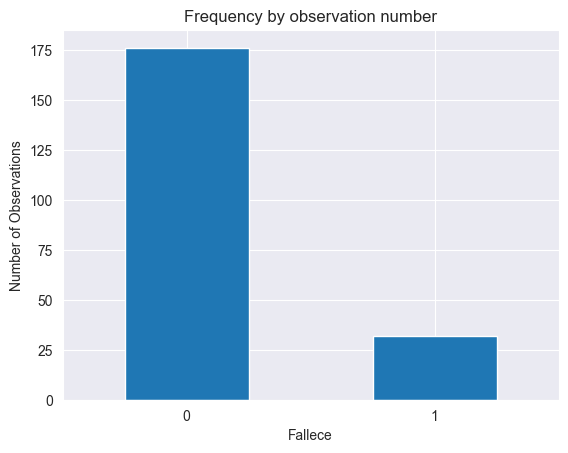

In [11]:
count_classes = df['Fallece'].value_counts(sort=True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.ylabel("Number of Observations")

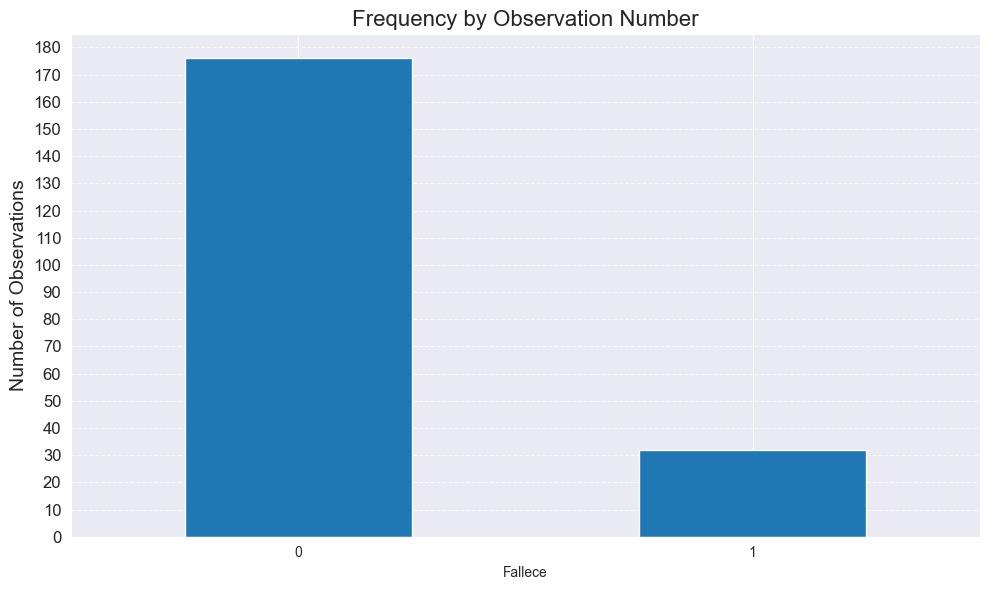

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el DataFrame df y has contado las clases
count_classes = df['Fallece'].value_counts(sort=True)

# Crear un gráfico de barras con un tamaño más grande
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura según lo necesites
count_classes.plot(kind='bar', rot=0)
plt.title("Frequency by Observation Number", fontsize=16)
plt.ylabel("Number of Observations", fontsize=14)

# Ajustar los ticks del eje Y para mayor detalle
# Usando una función para especificar los ticks
yticks = range(0, count_classes.max() + 10, 10)  # Ajusta el rango y el paso
plt.yticks(yticks, fontsize=12)  # Cambia el tamaño de fuente de los ticks

# Añadir grid para mayor claridad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()  # Ajusta el layout para que todo quepa bien
plt.show()

In [61]:

# Crear un DataFrame a partir del resultado de value_counts()
table = pd.DataFrame({'Clase': count_classes.index, 'Count': count_classes.values})

# Ordenar el DataFrame por la columna 'Count'
table = table.sort_values(by='Count', ascending=False)

# Mostrar la tabla
print(table)


   Clase  Count
0      0    176
1      1     32


## Rasgos a quitar 

In [62]:
# df = df.drop('Diag.Egr1', axis=1)
# # df = df.drop('Diag.Egr2', axis=1)

In [63]:
#definimos nuestras etiquetas y features
y = df['Fallece']
X = df.drop('Fallece', axis=1)


## Funciones para imprimir en txt

In [64]:
def printBestParameter( algoritmo, best_params):
    
    with open("configuracion_SMOTE.txt", "a") as archivo:
        archivo.write(f"Mejores parámetros del {algoritmo}.\n")
        archivo.write(f" {best_params}\n \n")
        

def printResultados(algoritmo, recall, f1, auc_roc):
    
    with open("Resultados_SMOTE.txt", "a") as archivo:
        archivo.write(f"Resultados del {algoritmo}. \n")
        archivo.write(f"Recall Score: {recall} \n")
        archivo.write(f"F1 Score: {f1}\n")
        archivo.write(f"AUC-ROC: {auc_roc} \n")
        archivo.write("\n")
    



## Inicio de escritura de resultados en archivos txt

In [65]:
with open("configuracion_SMOTE.txt", "a") as archivo:
    # Escribe algunas líneas en el archivo
    archivo.write("Sin Diag Egreso 1 y sin Diag Egreso 2:\n")
    archivo.write("\n")

with open("Resultados_SMOTE.txt", "a") as archivo:
    archivo.write("Sin Diag Egreso 1 y sin Diag Egreso 2:\n")
    archivo.write("\n")


# SMOTE

In [66]:
# Crear un objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# Imprimir la distribución antes y después del suavizado
print("Distribution before smoothing {}".format(Counter(y)))
print("Distribution labels after smoothing {}".format(Counter(y_train_resampled)))

Distribution before smoothing Counter({0: 176, 1: 32})
Distribution labels after smoothing Counter({0: 176, 1: 176})


# Set Split

In [67]:
# Dividir los datos en conjunto de entrenamiento + validación y conjunto de prueba
X_train, X_test_val, y_train, y_test_val = train_test_split(X_train_resampled, y_train_resampled, train_size=0.8, random_state=42)

# Dividir el conjunto de entrenamiento + validación en conjunto de entrenamiento y conjunto de validación
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [68]:
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))
print("Tamaño del conjunto de prueba:", len(X_test))


Tamaño del conjunto de entrenamiento: 281
Tamaño del conjunto de validación: 36
Tamaño del conjunto de prueba: 35


# KNN

In [69]:
algoritmo="KNN"

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

# Configurar la búsqueda en cuadrícula
clf = GridSearchCV( KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
clf.fit(X_val, y_val)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40, 50],
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

## Mejores parametros 

In [70]:

# Obtener los mejores parámetros
best_params = clf.best_params_
# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(best_params)


Mejores parámetros encontrados:
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


## Mejores parametros txt

In [71]:
printBestParameter(algoritmo=algoritmo, best_params=best_params )    

## Nuevo modelo con los mejores parametros

In [72]:
# Crear un nuevo modelo con los mejores hiperparámetros encontrados
best_knn_model = KNeighborsClassifier(**best_params)

# Entrenar el modelo con el conjunto de datos completo de entrenamiento + validación
best_knn_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)

## Metricas

In [73]:
targets=[1,0]

recall = recall_score(y_test, y_pred, labels=targets, average=None)
print("Recall Score:", recall)

f1 = f1_score(y_test, y_pred, labels=targets, average=None)
print("F1 Score:", f1)

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred, average=None)
print("AUC-ROC:", auc_roc)

# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# auc_pr = auc(recall, precision)
# print("AUC-PR:", auc_pr)


Recall Score: [0.86666667 0.75      ]
F1 Score: [0.78787879 0.81081081]
AUC-ROC: 0.8083333333333333


## Metricas txt

In [74]:
printResultados(algoritmo=algoritmo,recall=recall,f1=f1,auc_roc=auc_roc)

In [75]:
# from sklearn.metrics import classification_report
# print (classification_report(y_test, y_pred))

# Logistic regression

In [76]:
algoritmo="Regresion Logistica"

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': [ 'l1', 'l2', None]
}

# Configurar la búsqueda en cuadrícula
clf = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
clf.fit(X_val, y_val)

# Realizar predicciones en el conjunto de prueba
#y_pred = clf.predict(X_test)

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

C:\Users\anportal\AppData\Loca

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1')

## Mejores parametros

In [77]:

# Obtener los mejores parámetros
best_params = clf.best_params_

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(best_params)

Mejores parámetros encontrados:
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


## Mejores Parametros txt

In [78]:
printBestParameter(algoritmo=algoritmo, best_params=best_params)

## Nuevo modelo con los mejores parametros

In [79]:
# Crear un nuevo modelo con los mejores hiperparámetros encontrados
best_lr_model = LogisticRegression(**best_params)

# Entrenar el modelo con el conjunto de datos completo de entrenamiento + validación
best_lr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_lr_model.predict(X_test)

In [80]:
# # Resultado del algorimo: [probabilidad de que viva: probabilidad de que muera]
# prob = clf.predict_proba(X)
# np.savetxt("prob.csv", prob, delimiter=',')

In [81]:
# # Resultado del algorimo: [probabilidad de que viva: probabilidad de que muera]
# prob = clf.predict_proba(x_pred_v)
# prob

## Metricas

In [82]:
# Metricas
val_mae = mean_absolute_error(y_test , y_pred)
print("Validation MAE: {}".format(val_mae))

val_mse = mean_squared_error(y_test , y_pred)
print("Validation MSE: {}".format(val_mse))

val_rmse = mean_squared_error(y_test , y_pred, squared=False)
print("Validation RMSE: {}".format(val_rmse))

Validation MAE: 0.3142857142857143
Validation MSE: 0.3142857142857143
Validation RMSE: 0.560611910581388


In [83]:
targets=[1,0]

recall = recall_score(y_test, y_pred, labels=targets, average=None)
print("Recall Score:", recall)

f1 = f1_score(y_test, y_pred, labels=targets, average=None)
print("F1 Score:", f1)

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred, average=None)
print("AUC-ROC:", auc_roc)

# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# auc_pr = auc(recall, precision)
# print("AUC-PR:", auc_pr)

Recall Score: [0.66666667 0.7       ]
F1 Score: [0.64516129 0.71794872]
AUC-ROC: 0.6833333333333332


## Metricas txt

In [84]:
printResultados(algoritmo=algoritmo,recall=recall,f1=f1,auc_roc=auc_roc)

In [85]:
# # Cross Validation
# print(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

# MLP

In [86]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score

algoritmo="MLP"

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50), (30,30), (100,)],
    'activation': ['logistic', 'relu', 'tanh'],
    'solver': ['adam', 'sgd','lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [200, 300, 400],
}

# Crear el objeto GridSearchCV con balanced_accuracy como métrica
mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, scoring='f1')

# Ajustar el modelo al conjunto de entrenamiento
mlp.fit(X_val, y_val)

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['logistic', 'relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (50, 50), (30, 30),
                                                (100,)],
                         'max_iter': [200, 300, 400],
                         'solver': ['adam', 'sgd', 'lbfgs']},
             scoring='f1')

## Mejores parametros 

In [87]:

# Obtener los mejores hiperparámetros
best_params = mlp.best_params_
print("Mejores hiperparámetros:", best_params)

# Predecir en el conjunto de prueba con el modelo ajustado
# y_pred = mlp.predict(X_test)

# # Calcular la precisión balanceada en el conjunto de prueba
# balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
# print("Precisión balanceada en el conjunto de prueba:", balanced_accuracy)

Mejores hiperparámetros: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'max_iter': 300, 'solver': 'adam'}


## Mejores parametros txt

In [88]:
printBestParameter(algoritmo=algoritmo,best_params=best_params)

## Nuevo modelo con los mejores parametros

In [89]:
best_mlp_model = MLPClassifier(**best_params, random_state=42)

best_mlp_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba con el modelo ajustado
y_pred = best_mlp_model.predict(X_test)

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



## Metricas

In [90]:
# Metricas
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")

MAE: 0.08571428571428572
MSE: 0.08571428571428572
MSE: 0.29277002188455997


In [91]:
targets=[1,0]

recall = recall_score(y_test, y_pred, labels=targets, average=None)
print("Recall Score:", recall)

f1 = f1_score(y_test, y_pred, labels=targets, average=None)
print("F1 Score:", f1)

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred, average=None)
print("AUC-ROC:", auc_roc)

# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# auc_pr = auc(recall, precision)
# print("AUC-PR:", auc_pr)

Recall Score: [0.93333333 0.9       ]
F1 Score: [0.90322581 0.92307692]
AUC-ROC: 0.9166666666666666


## Metricas txt

In [92]:
printResultados(algoritmo=algoritmo, recall=recall, f1=f1, auc_roc=auc_roc)

In [93]:

# cv_scores = cross_val_score(best_model, X, y, cv=10, scoring='recall')
# print(cv_scores)

In [94]:
# Obtener nombres de características
feature_names = df.columns.tolist()

# Obtener nombres de clases (si estás trabajando en un problema de clasificación)
class_names = df['Fallece'].unique().tolist()  # Suponiendo que 'clase' es la columna de clases en tus datos


# LIME

In [95]:
x_pred_f = y_test.loc[df.Fallece == 1]
x_pred_f = x_pred_f[1:2]
x_pred_f = x_pred_f.drop("Fallece", axis =1)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [96]:
# Obtener la primera instancia de X_test
prediccion = best_mlp_model.predict(X_test[:1])

print(prediccion)

print(y_test[:1])

[0]
155    0
Name: Fallece, dtype: int64


In [97]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show
from interpret.blackbox import LimeTabular

In [98]:
lime = LimeTabular(best_mlp_model, X_train)


lime = LimeTabular(best_mlp_model, X_train)



show(lime.explain_local(X_test[:10], y_test[:10]), 0)

In [99]:
# Crear un objeto explainer LIME para datos tabulares
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=class_names)

# Seleccionar una instancia para explicar (por ejemplo, la primera instancia del conjunto de prueba)
instance = X_test[0]

# Explicar la predicción para la primera instancia del conjunto de prueba
explanation = explainer.explain_instance(instance, mlp.predict_proba, num_features=2)

AttributeError: 'LimeTabular' object has no attribute 'lime_tabular'

In [100]:
probabilidades = best_mlp_model.predict_proba(X_test[:10])


print(probabilidades)

[[0.99297338 0.00702662]
 [0.90202322 0.09797678]
 [0.23775245 0.76224755]
 [0.11617508 0.88382492]
 [0.02863971 0.97136029]
 [0.99750957 0.00249043]
 [0.80531866 0.19468134]
 [0.99449264 0.00550736]
 [0.06008141 0.93991859]
 [0.03706455 0.96293545]]
